In [1]:
import math
import numpy as np
from scipy.sparse import coo_matrix
import scipy.sparse.linalg
import matplotlib.pyplot as plt

In [2]:
alphas_77 = np.load("./hs_tomography/alphas_77.npy")
alphas_195 = np.load("./hs_tomography/alphas_195.npy")

In [4]:
def construct_X(M, alphas, Np = None):
    Np = Np if Np else math.ceil(math.sqrt(2) * M)
    No = alphas.shape[0]    # Number of orientations
    N =  No * Np            # flattened array length of intensitie measurements
    D = M * M               # flattened array length of tomogram

    # Compute two indices a and b for each pixel
    ja = np.mgrid[0:D] % M
    jb = (np.mgrid[0:D] - ja) / M

    C = np.array([ja, jb])

    # Move pixels such that the middle pixel (M/2, M/2) is in the origin of the coordinate system
    C_moved = C - np.array([[M / 2],[M / 2]])

    all_weights = []
    all_i_indices = []
    all_j_indices = []

    for io in range(No):

        alpha = np.radians(alphas[io])
        # Calculate unit vector in direction of sensor array using 2D rotation matrix
        # negate the y value, as coordinate system goes the "opposite" direction
        n = np.array([[math.cos(alpha)], [-math.sin(alpha)]])
        p = np.dot(n.T, C_moved) 

        p = p[0]

        # Center of sensor array is at origin => add half the length of the sensor array
        p = p + Np / 2

        # Calculate index of the two sensors
        idx_sensor1 = np.floor(p) + Np * io
        idx_sensor2 = np.ceil(p) + Np * io

        # Calculate the weights of the two sensors
        weight2 = p - np.floor(p)
        weight1 = 1 - weight2

        # Calculate the index of the pixels
        idx_pixel1 = np.mgrid[0:D]
        idx_pixel2 = np.mgrid[0:D]

        weights = np.append(weight1, weight2)
        idx_sensor = np.append(idx_sensor1, idx_sensor2)
        idx_pixel = np.append(idx_pixel1, idx_pixel2)

        all_weights.extend(weights)
        all_j_indices.extend(idx_pixel)
        all_i_indices.extend(idx_sensor)


    all_weights = np.array(all_weights)
    all_i_indices = np.array(all_i_indices)
    all_j_indices = np.array(all_j_indices)

    X = coo_matrix((all_weights, (all_i_indices, all_j_indices)), shape=(N, D), dtype = np.float32)
    return X

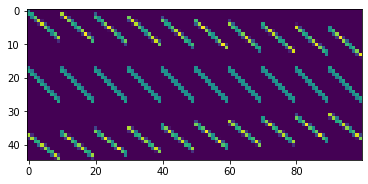

In [5]:
X = construct_X(M=195, alphas=alphas_195, Np=275)
X_small = construct_X(M=10, alphas=np.array([-33, 1, 42]), Np=15)
plt.imshow(X_small.todense())

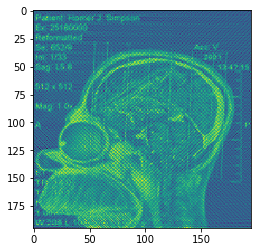

In [6]:
y = np.load("hs_tomography/y_195.npy", allow_pickle=True)
alphas = np.load("hs_tomography/alphas_195.npy", allow_pickle=True)

beta, solution, *_ = scipy.sparse.linalg.lsqr(X, y, atol=1e-3, btol=1e-3)

assert solution == 1
img = beta.reshape((195, 195))
plt.imshow(img)
plt.show()